In [812]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [813]:
country_to_predict="Yemen"

**ARIMA**


In [814]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
441,1970-01-01,36.820,Yemen
442,1971-01-01,37.888,Yemen
443,1972-01-01,38.981,Yemen
444,1973-01-01,40.093,Yemen
445,1974-01-01,41.219,Yemen


In [815]:
del df["Country"]

In [816]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [817]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

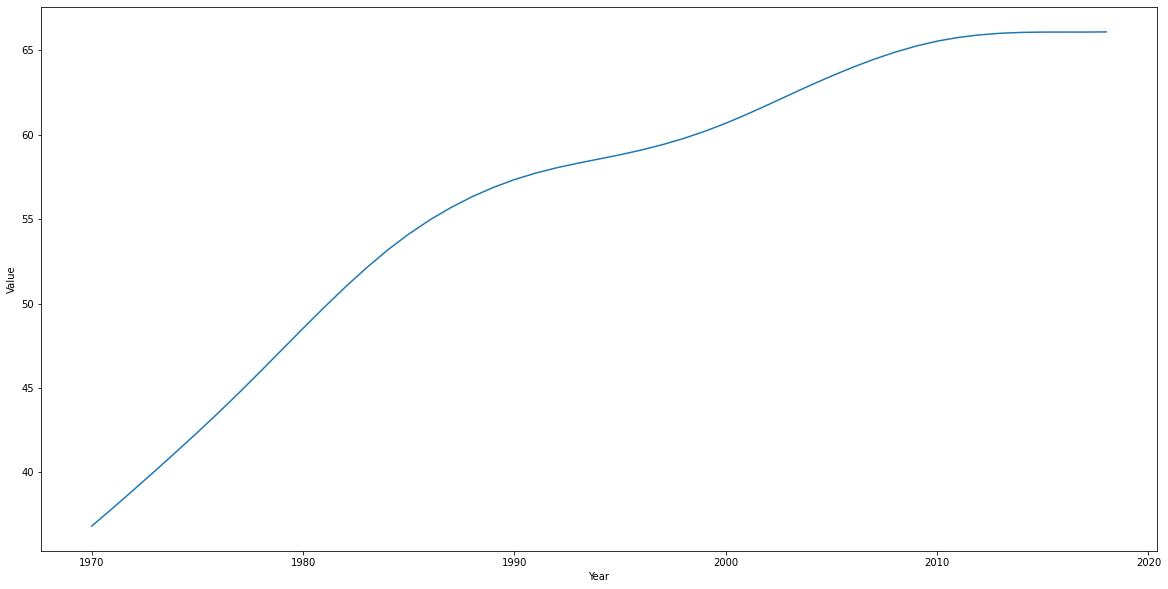

In [818]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [819]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  39.560833
1976-01-01  40.680833
1977-01-01  41.825000
1978-01-01  42.994833
1979-01-01  44.190167
1980-01-01  45.409000
1981-01-01  46.644667
1982-01-01  47.884833
1983-01-01  49.112167
1984-01-01  50.307167
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  2.075438
1976-01-01  2.113405
1977-01-01  2.156865
1978-01-01  2.208690
1979-01-01  2.264169
1980-01-01  2.312690
1981-01-01  2.340836
1982-01-01  2.338133
1983-01-01  2.297786
1984-01-01  2.218620


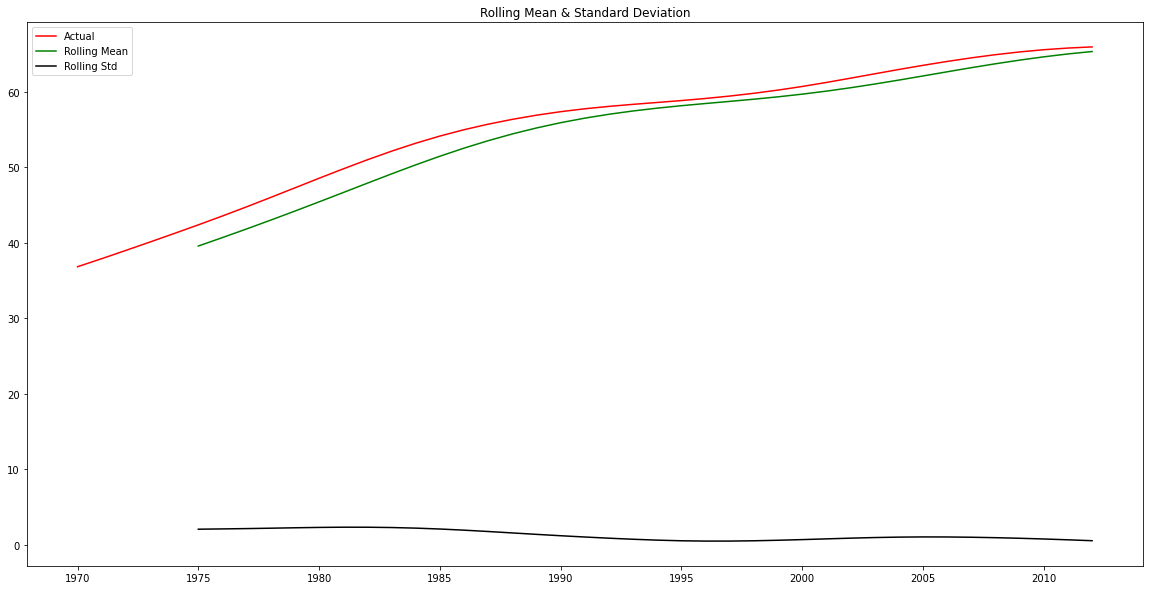

In [820]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [821]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic         -5.665355e+00
p-value                 9.178491e-07
Lags Used               5.000000e+00
No. of Obs              3.700000e+01
Critical Value (1%)    -3.620918e+00
Critical Value (5%)    -2.943539e+00
Critical Value (10%)   -2.610400e+00
dtype: float64


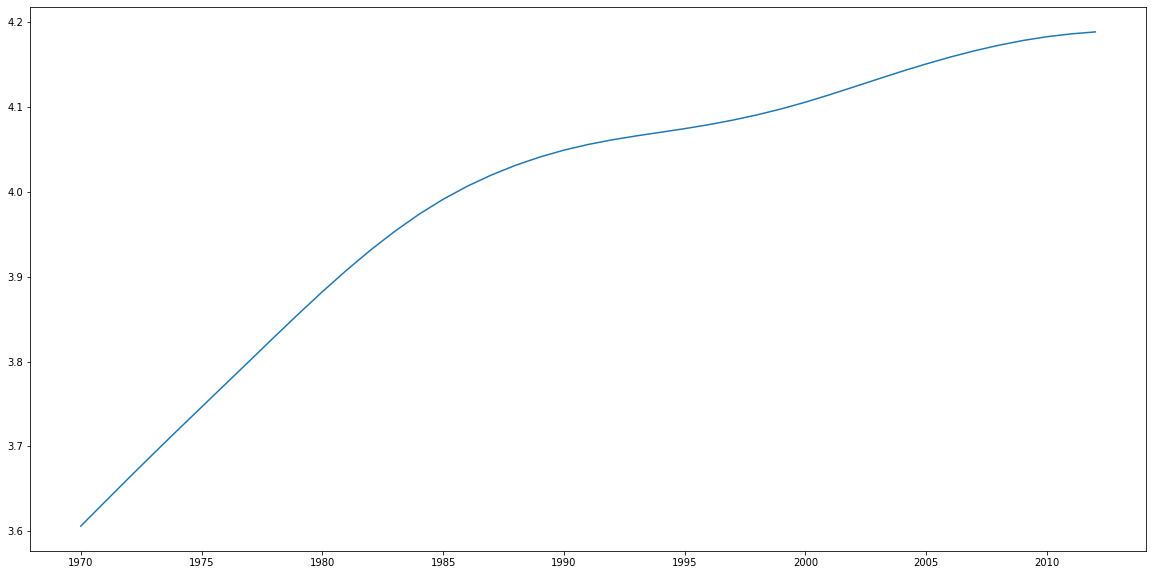

In [822]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

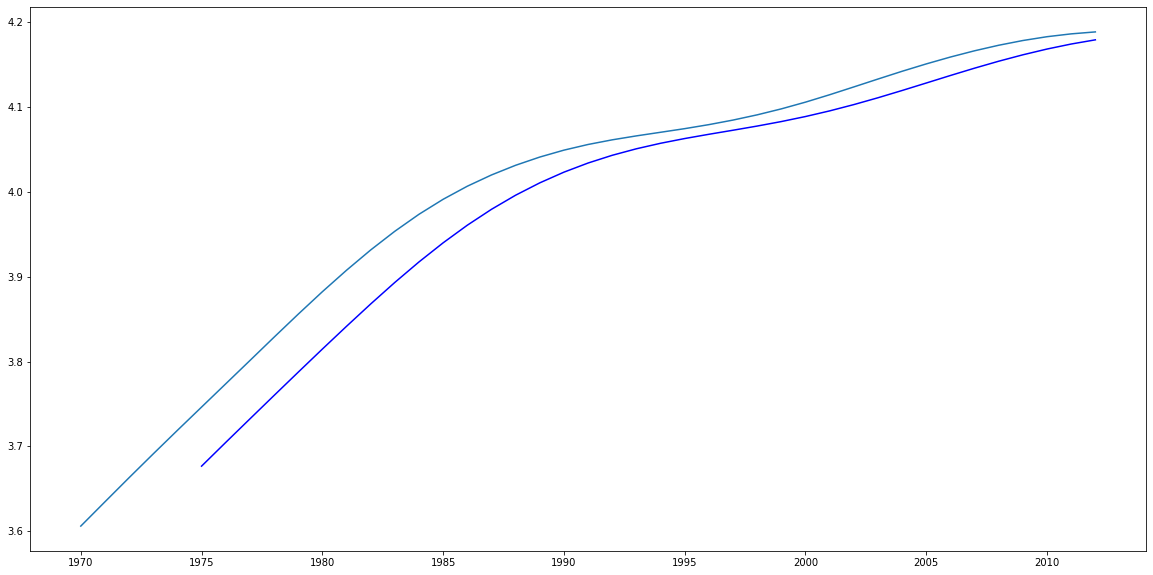

In [823]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [824]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.069607
1976-01-01,0.069049
1977-01-01,0.068773
1978-01-01,0.068661


In [825]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.069607
1976-01-01,0.069049
1977-01-01,0.068773
1978-01-01,0.068661
1979-01-01,0.068362


In [826]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

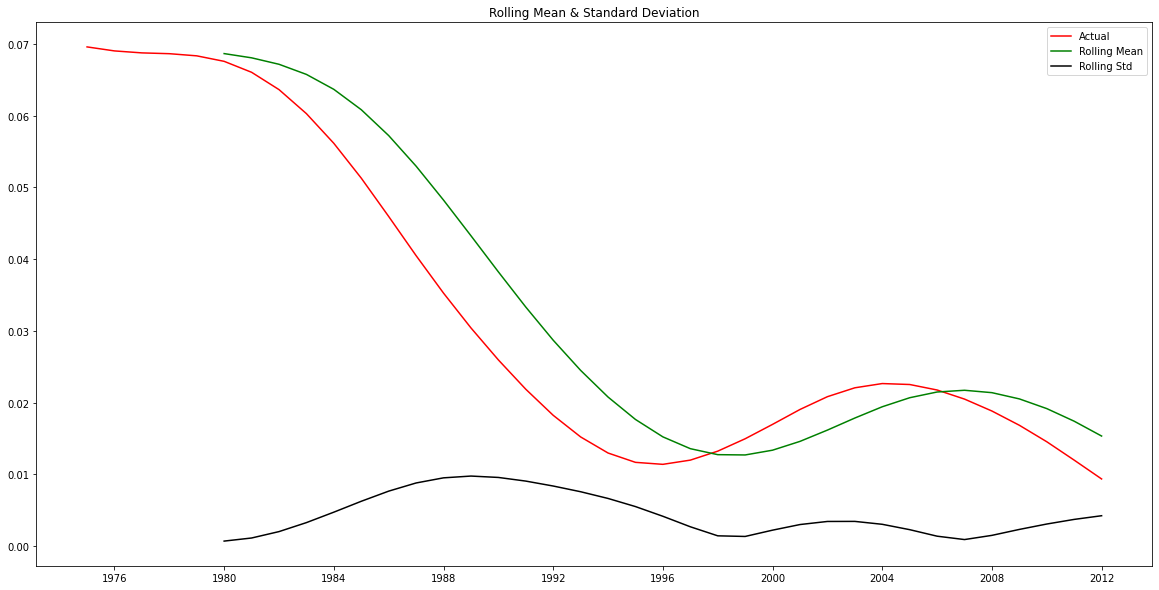

Dickey-Fuller Test: 
Test Statistic          -3.804585
p-value                  0.002861
Lags Used                9.000000
No. of Obs              28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
dtype: float64


In [827]:
stationarity(df_log_diff)

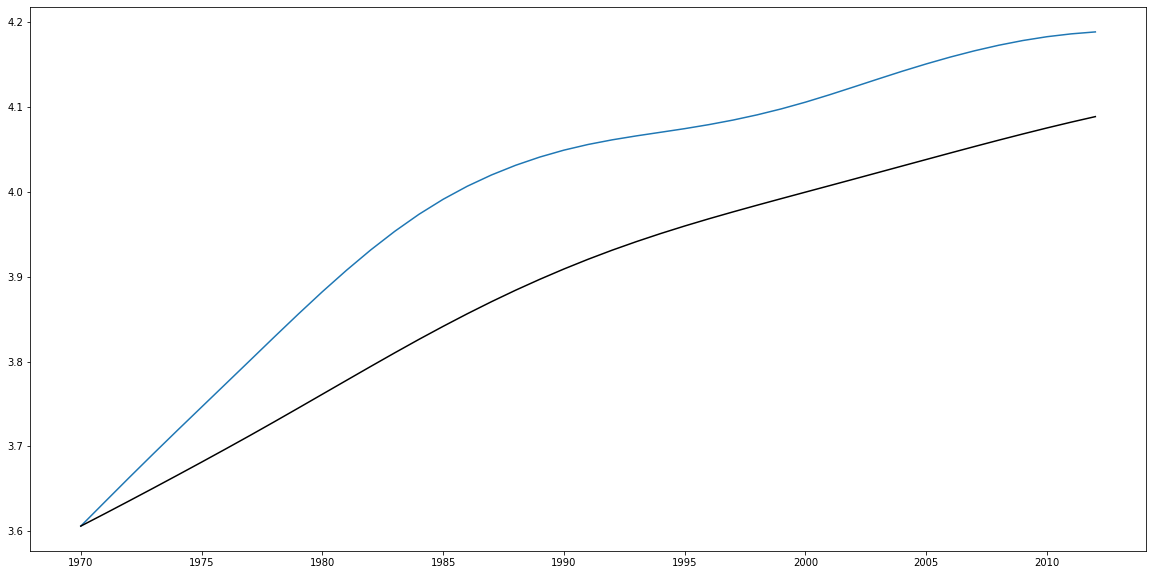

In [828]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

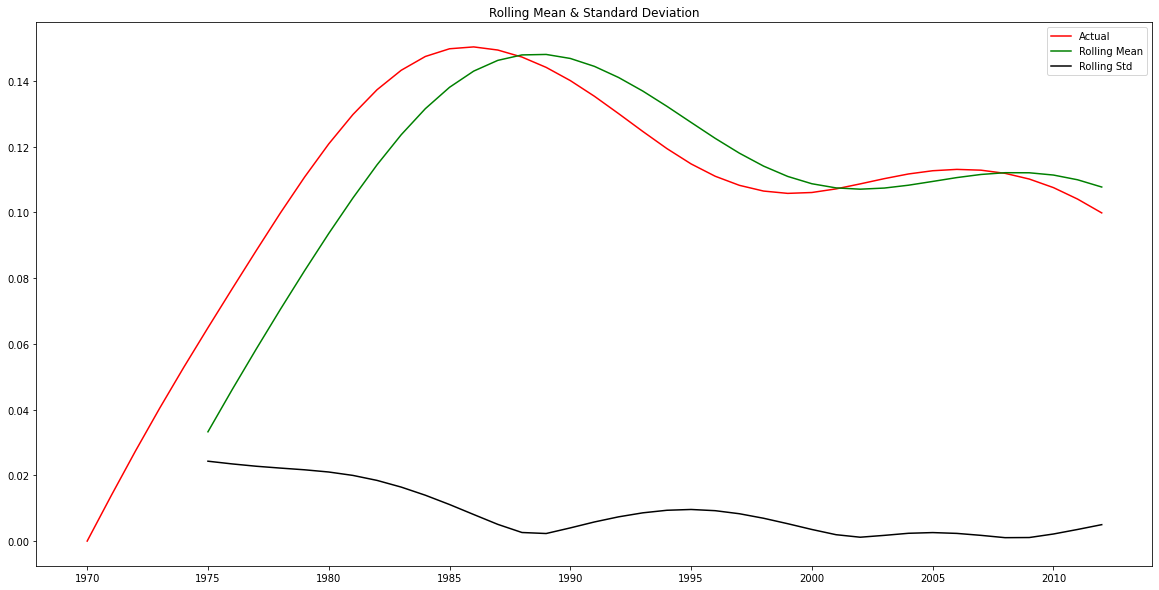

Dickey-Fuller Test: 
Test Statistic          -2.958888
p-value                  0.038916
Lags Used                3.000000
No. of Obs              39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
dtype: float64


In [829]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

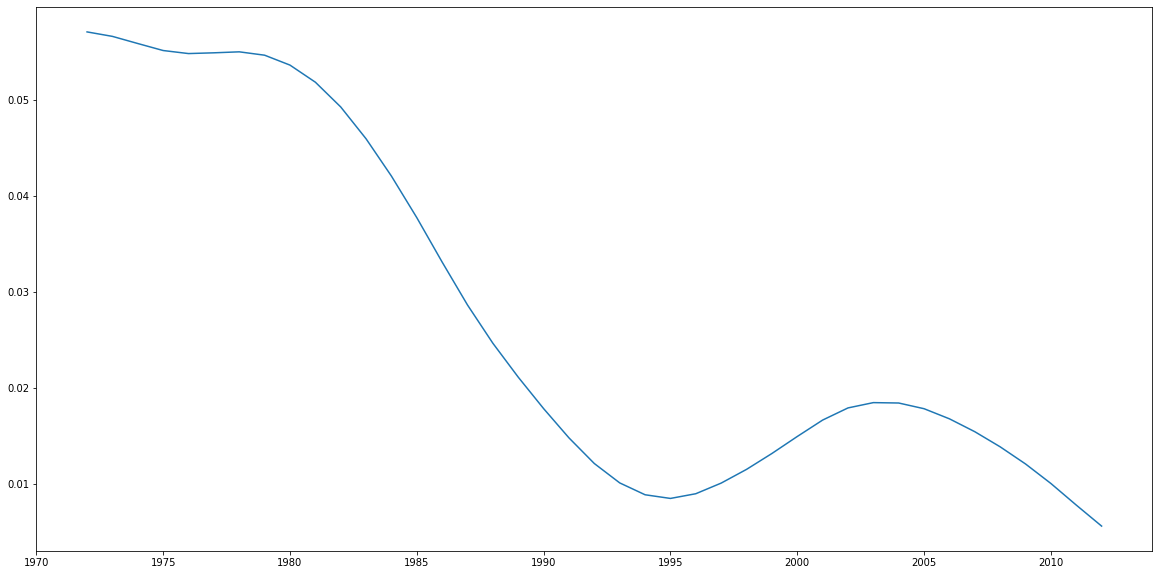

In [830]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift(2)
plt.plot(df_shift)

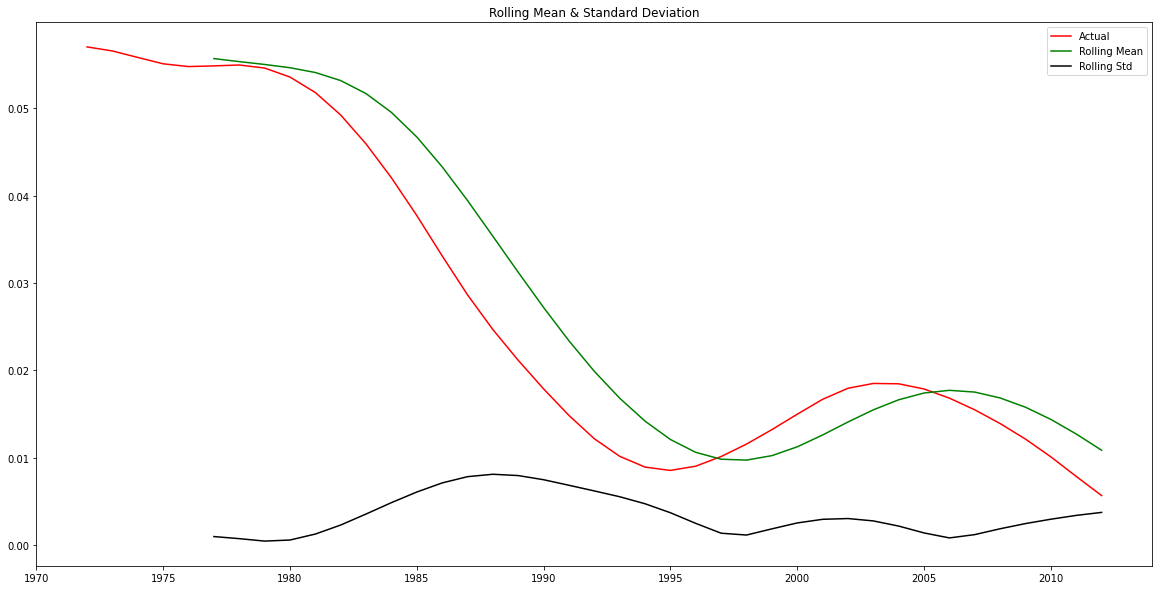

Dickey-Fuller Test: 
Test Statistic          -3.167623
p-value                  0.021937
Lags Used               10.000000
No. of Obs              30.000000
Critical Value (1%)     -3.669920
Critical Value (5%)     -2.964071
Critical Value (10%)    -2.621171
dtype: float64


In [831]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

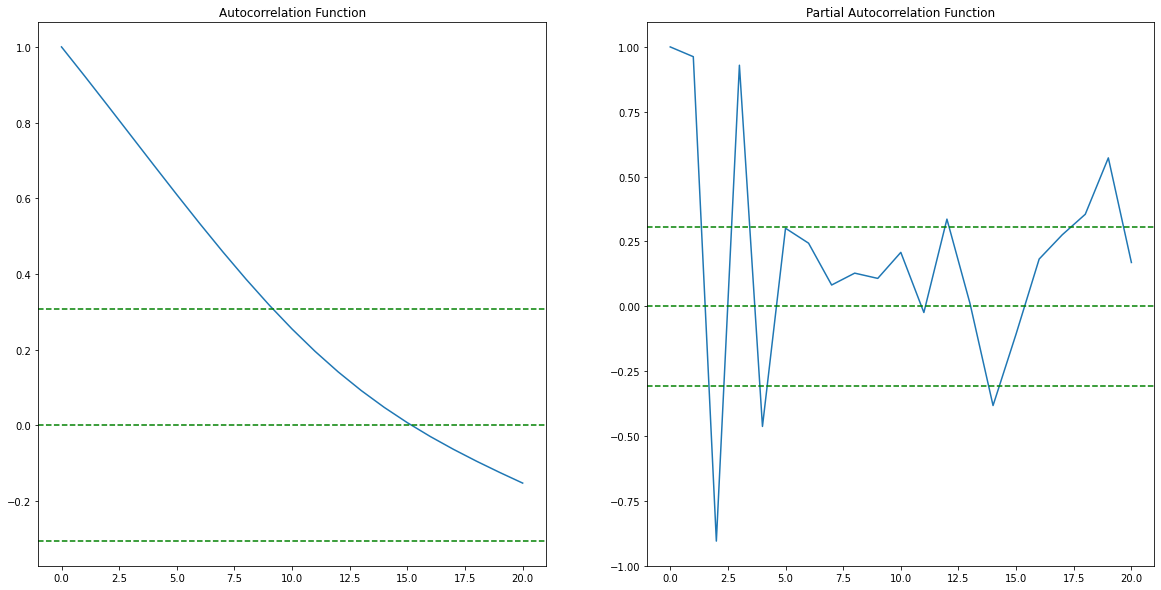

In [832]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(train_df, nlags=20)
lag_pacf=pacf(train_df, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


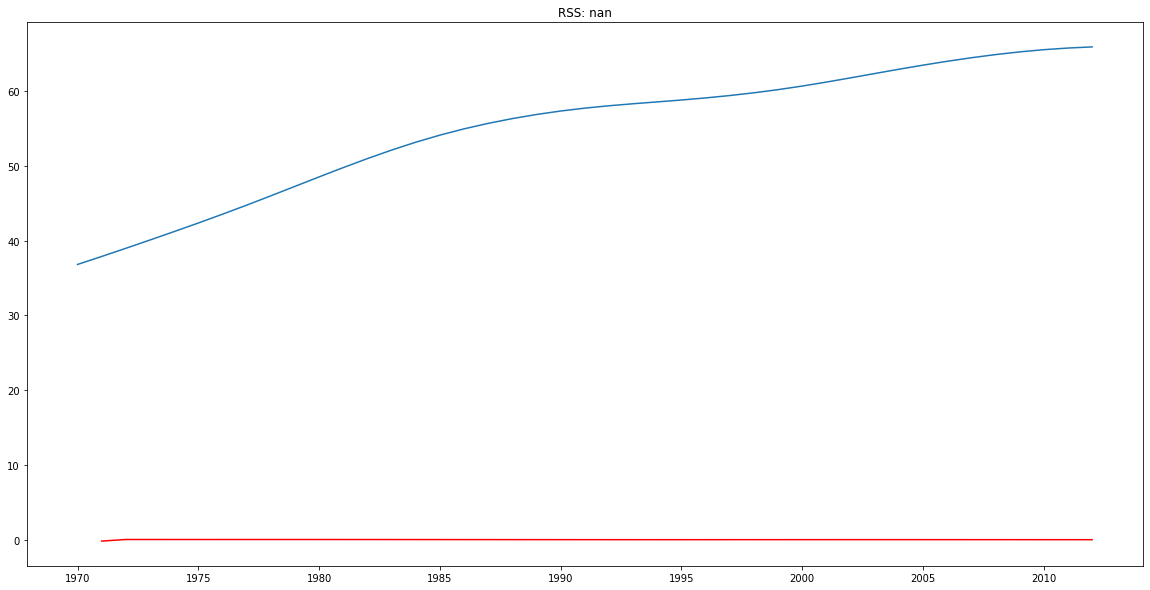

In [868]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(3,1,0))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [869]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1971-01-01   -0.184667
1972-01-01    0.028593
1973-01-01    0.028290
1974-01-01    0.027688
1975-01-01    0.027184
Freq: AS-JAN, dtype: float64


In [870]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1971-01-01   -0.184667
1972-01-01   -0.156073
1973-01-01   -0.127783
1974-01-01   -0.100095
1975-01-01   -0.072911
Freq: AS-JAN, dtype: float64


In [871]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [872]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


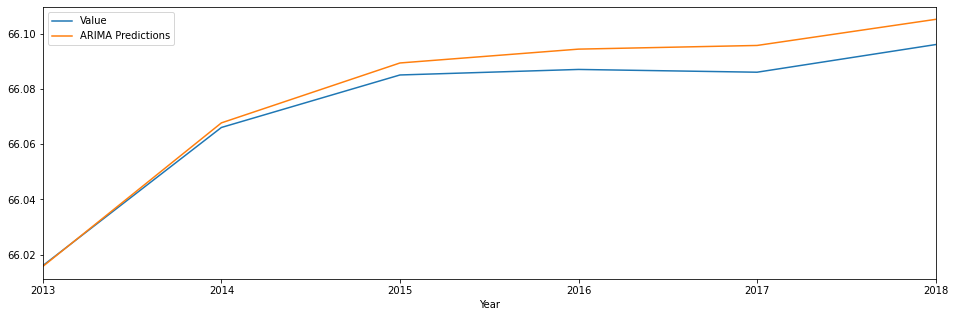

In [873]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [874]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 4.213343245104776e-05
RMSE Error: 0.006491027072124084
Mean: 56.3988163265306


In [875]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,66.132834,Yemen
2020,66.186989,Yemen
2021,66.273660,Yemen
2022,66.396739,Yemen
2023,66.558011,Yemen
2024,66.757289,Yemen
2025,66.992641,Yemen


In [876]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [877]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,66.016,66.015709
2014-01-01,66.066,66.067662
2015-01-01,66.085,66.089343
2016-01-01,66.087,66.094352
2017-01-01,66.086,66.095682
2018-01-01,66.096,66.105127


**LSTM**

In [973]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [974]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,66.066
2015-01-01,66.085
2016-01-01,66.087
2017-01-01,66.086
2018-01-01,66.096


In [975]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [976]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [977]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(32, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [978]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3812
Epoch 2/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 3/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 5/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 6/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/20
31/31 [==============================] - 0s 4ms/step - loss: 9.6084e-04
Epoch 9/20
31/31 [==============================] - 0s 4ms/step - loss: 7.2936e-04
Epoch 10/20
31/31 [==============================] - 0s 4ms/step - loss: 8.5369e-04
Epoch 11/20
31/31 [==============================] - 0s 4ms/step - loss: 7.8503e-04
Epoch 12/20
31/31 [==============================] - 0s 4ms/step - loss: 5.7428e-04
Epoch 13/20
31/31 [==========

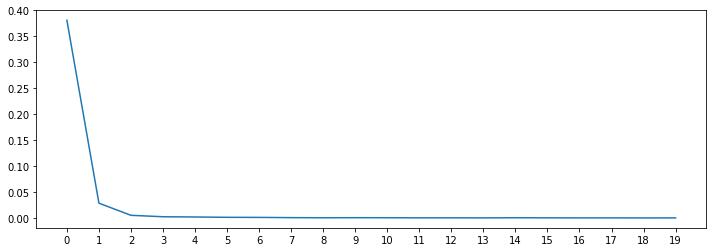

In [979]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [980]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [981]:
lstm_predictions_scaled

[array([0.97890586], dtype=float32),
 array([0.9831461], dtype=float32),
 array([0.9865187], dtype=float32),
 array([0.9890361], dtype=float32),
 array([0.99089295], dtype=float32),
 array([0.99228454], dtype=float32)]

In [982]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [983]:
lstm_predictions

array([[65.30616043],
       [65.42955068],
       [65.52769362],
       [65.60095002],
       [65.65498475],
       [65.69548001]])

In [984]:
test_df['LSTM_Predictions'] = lstm_predictions

In [985]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,66.016,66.015709,65.306160
2014-01-01,66.066,66.067662,65.429551
2015-01-01,66.085,66.089343,65.527694
2016-01-01,66.087,66.094352,65.600950
2017-01-01,66.086,66.095682,65.654985
2018-01-01,66.096,66.105127,65.695480


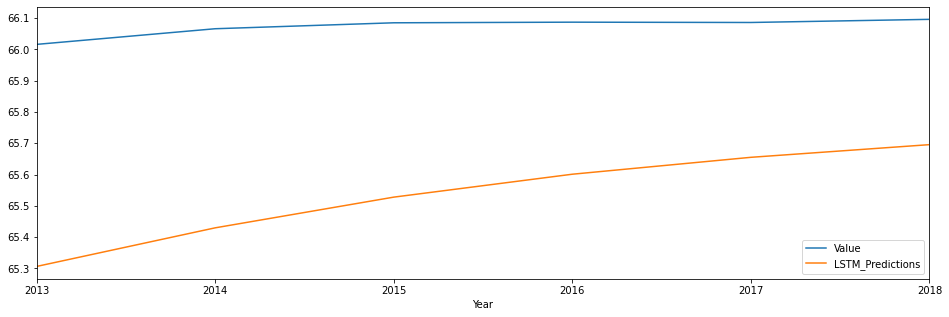

In [986]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [987]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.3003275586101527
RMSE Error: 0.5480214946607046
Mean: 56.3988163265306


In [988]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [989]:
lstm_predictions_scaled

[array([0.97890586], dtype=float32),
 array([0.9831461], dtype=float32),
 array([0.9865187], dtype=float32),
 array([0.9890361], dtype=float32),
 array([0.99089295], dtype=float32),
 array([0.99228454], dtype=float32),
 array([0.9933786], dtype=float32),
 array([0.9944468], dtype=float32),
 array([0.9958774], dtype=float32),
 array([0.9970922], dtype=float32),
 array([0.99810207], dtype=float32),
 array([0.9989698], dtype=float32)]

In [990]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [991]:
lstm_predictions

array([[65.30616043],
       [65.42955068],
       [65.52769362],
       [65.60095002],
       [65.65498475],
       [65.69548001],
       [65.72731667],
       [65.75840229],
       [65.80003191],
       [65.83538265],
       [65.86477021],
       [65.89002099]])

In [992]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,65.695480,Yemen
2020,65.727317,Yemen
2021,65.758402,Yemen
2022,65.800032,Yemen
2023,65.835383,Yemen
2024,65.864770,Yemen
2025,65.890021,Yemen


In [993]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [994]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
485,2014,66.066
486,2015,66.085
487,2016,66.087
488,2017,66.086
489,2018,66.096


In [995]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
485,2014-01-01,66.066
486,2015-01-01,66.085
487,2016-01-01,66.087
488,2017-01-01,66.086
489,2018-01-01,66.096


In [996]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [997]:
from fbprophet import Prophet

In [998]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [999]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,32.574464,66.985950,67.347390,32.459996,32.682879,34.587212,34.587212,34.587212,34.587212,34.587212,34.587212,0.0,0.0,0.0,67.161676
45,2015-01-01,32.991576,67.296193,67.813903,32.765929,33.217783,34.571913,34.571913,34.571913,34.571913,34.571913,34.571913,0.0,0.0,0.0,67.563489
46,2016-01-01,33.408688,67.568994,68.345621,33.035989,33.766226,34.560061,34.560061,34.560061,34.560061,34.560061,34.560061,0.0,0.0,0.0,67.968749
47,2017-01-01,33.826942,67.870149,68.978491,33.285567,34.341957,34.603664,34.603664,34.603664,34.603664,34.603664,34.603664,0.0,0.0,0.0,68.430607
48,2018-01-01,34.244054,68.071041,69.555377,33.496706,34.920847,34.587212,34.587212,34.587212,34.587212,34.587212,34.587212,0.0,0.0,0.0,68.831266


In [1000]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [1001]:
prophet_pred = prophet_pred.set_index("Year")

In [1002]:
prophet_pred.index.freq = "YS"

In [1003]:
prophet_pred

,Pred
Year,
2013-01-01,66.761016
2014-01-01,67.161676
2015-01-01,67.563489
2016-01-01,67.968749
2017-01-01,68.430607
2018-01-01,68.831266


In [1004]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,66.016,66.015709,65.306160,66.761016
2014-01-01,66.066,66.067662,65.429551,67.161676
2015-01-01,66.085,66.089343,65.527694,67.563489
2016-01-01,66.087,66.094352,65.600950,67.968749
2017-01-01,66.086,66.095682,65.654985,68.430607
2018-01-01,66.096,66.105127,65.695480,68.831266


In [1005]:
import seaborn as sns

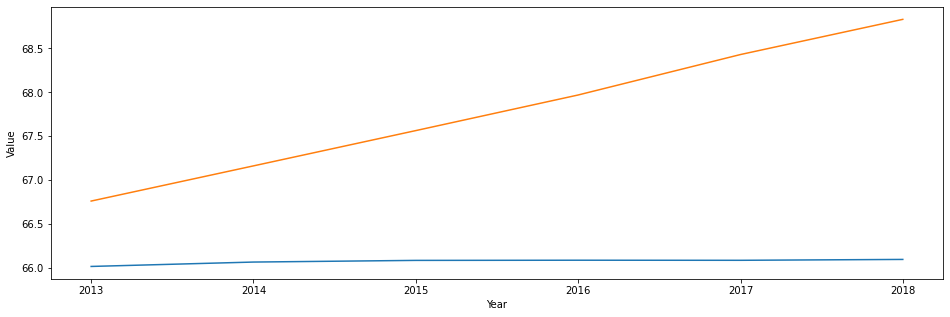

In [1006]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [1007]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 3.4102212051088423
RMSE Error: 1.8466784249318673
Mean: 56.3988163265306


In [1008]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [1009]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [1010]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,69.233079,Yemen
2020,69.638339,Yemen
2021,70.100197,Yemen
2022,70.500857,Yemen
2023,70.902669,Yemen
2024,71.307929,Yemen
2025,71.769787,Yemen


In [1011]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [1012]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 66.07266666666666


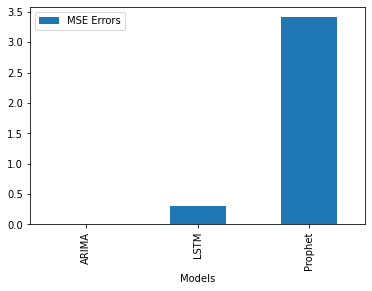

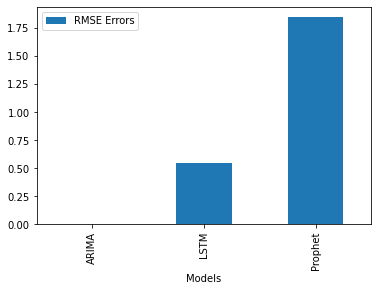

In [1013]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [1014]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.006491,0.000042,Yemen
1,LSTM,0.548021,0.300328,Yemen
2,Prophet,1.846678,3.410221,Yemen


In [1015]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [1016]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,66.016,66.015709,65.306160,66.761016,Yemen
2014,66.066,66.067662,65.429551,67.161676,Yemen
2015,66.085,66.089343,65.527694,67.563489,Yemen
2016,66.087,66.094352,65.600950,67.968749,Yemen
2017,66.086,66.095682,65.654985,68.430607,Yemen
2018,66.096,66.105127,65.695480,68.831266,Yemen


In [1017]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

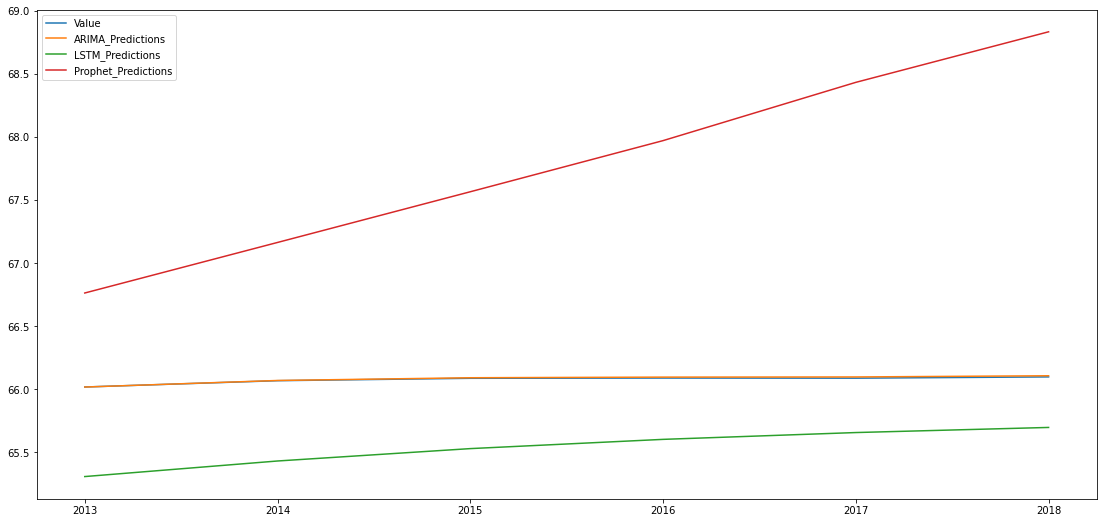

In [1018]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))